In [202]:
import netCDF4
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import math as m

In [2]:
import random
from scipy.optimize import minimize

### Reading data from file

In [3]:
f = netCDF4.Dataset('rtofs_glo_3dz_f024_daily_3zvio.nc')
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    title: HYCOM ATLb2.00
    institution: National Centers for Environmental Prediction
    source: HYCOM archive file
    experiment: 92.4
    history: archv2ncdf3z
    dimensions(sizes): MT(1), Y(3298), X(4500), Depth(33)
    variables(dimensions): float64 MT(MT), float64 Date(MT), float32 Depth(Depth), int32 Y(Y), int32 X(X), float32 Latitude(Y,X), float32 Longitude(Y,X), float32 v(MT,Depth,Y,X)
    groups: 



In [4]:
print(f.variables.keys()) # get all variable names

odict_keys(['MT', 'Date', 'Depth', 'Y', 'X', 'Latitude', 'Longitude', 'v'])


In [5]:
temp = f.variables['v']
print(temp)

<class 'netCDF4._netCDF4.Variable'>
float32 v(MT, Depth, Y, X)
    coordinates: Longitude Latitude Date
    standard_name: northward_sea_water_velocity
    units: m/s
    _FillValue: 1.2676506e+30
    valid_range: [-2.6110384  2.6092384]
    long_name:  v-veloc. [92.4H]
unlimited dimensions: MT
current shape = (1, 33, 3298, 4500)
filling on


In [6]:
for d in f.dimensions.items():
    print(d)

('MT', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'MT', size = 1
)
('Y', <class 'netCDF4._netCDF4.Dimension'>: name = 'Y', size = 3298
)
('X', <class 'netCDF4._netCDF4.Dimension'>: name = 'X', size = 4500
)
('Depth', <class 'netCDF4._netCDF4.Dimension'>: name = 'Depth', size = 33
)


In [7]:
print(temp.dimensions)
print(temp.shape)

('MT', 'Depth', 'Y', 'X')
(1, 33, 3298, 4500)


In [8]:
mt = f.variables['MT']
depth = f.variables['Depth']
x,y = f.variables['X'], f.variables['Y']
v = f.variables['v']
print(mt)
print(x)
print(v)

<class 'netCDF4._netCDF4.Variable'>
float64 MT(MT)
    long_name: time
    units: days since 1900-12-31 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: MT
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
int32 X(X)
    point_spacing: even
    axis: X
unlimited dimensions: 
current shape = (4500,)
filling on, default _FillValue of -2147483647 used

<class 'netCDF4._netCDF4.Variable'>
float32 v(MT, Depth, Y, X)
    coordinates: Longitude Latitude Date
    standard_name: northward_sea_water_velocity
    units: m/s
    _FillValue: 1.2676506e+30
    valid_range: [-2.6110384  2.6092384]
    long_name:  v-veloc. [92.4H]
unlimited dimensions: MT
current shape = (1, 33, 3298, 4500)
filling on


#### Shapes of basic arrays

In [9]:
print(x.shape[0])
print(y.shape[0])

4500
3298


#### Time and depth variables

In [10]:
time = mt[:]  # Reads the netCDF variable MT, array of one element
print(time)
dep = depth[:] # examine depth array
print(dep)

[42975.]
[   0.   10.   20.   30.   50.   75.  100.  125.  150.  200.  250.  300.
  400.  500.  600.  700.  800.  900. 1000. 1100. 1200. 1300. 1400. 1500.
 1750. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500.]


### Extracting lats and lons 

In [11]:
xx,yy = x[:],y[:]
print('shape of temp variable: %s' % repr(temp.shape))
tempslice = temp[0, dep < 100., yy > yy.max()/2, xx > xx.max()/2]
print('shape of temp slice: %s' % repr(tempslice.shape))

shape of temp variable: (1, 33, 3298, 4500)
shape of temp slice: (6, 1649, 2250)


In [12]:
lat, lng = f.variables['Latitude'], f.variables['Longitude']
print(lng)

<class 'netCDF4._netCDF4.Variable'>
float32 Longitude(Y, X)
    standard_name: longitude
    units: degrees_east
    modulo: 360 degrees
unlimited dimensions: 
current shape = (3298, 4500)
filling on, default _FillValue of 9.969209968386869e+36 used



In [13]:
# extract lat/lon values (in degrees) to numpy arrays
latvals = lat[:]; lngvals = lng[:] 
# a function to find the index of the point closest pt (in squared distance) to give lat/lon value.
def getclosest_ij(lats,lngs,latpt,lngpt):
    # find squared distance of every point on grid
    dist_sq = (lats-latpt)**2 + (lngs-lngpt)**2  
    # 1D index of minimum dist_sq element
    minindex_flat = dist_sq.argmin()    
    # Get 2D index for latvals and lonvals arrays from 1D index
    return np.unravel_index(minindex_flat, lats.shape)
iy_min, ix_min = getclosest_ij(latvals, lngvals, 50., -140)
print(iy_min, ix_min)

3296 50


## Initial attempt of point search

### Решаем задачу: зная широту и долготу, найти квадрат (4 точки со значениями y и x) такой, что исходная точка лежит в этом квадрате

In [14]:
def pointSearch(pLat, pLng):
    goalX = -1
    goalY = -1
    epsX = 100.
    epsY = 100.
    for i in range(x.shape[0] - 1):
        if ((lngvals[0, i] - 255. <= pLng) & (lngvals[0, i + 1] - 255. > pLng) & (epsX > 0.01)):
            goalX = i
            epsX = pLng -  lngvals[0, i] + 255.
    if (goalX == -1):
        print('Smth with X went wrong')

    for j in range(y.shape[0] - 1):
        if (lngvals[j, goalX] - 255. > pLng):
            while (lngvals[j, goalX] - 255. > pLng):
                goalX -= 1
        if (lngvals[j, goalX + 1] - 255. < pLng):
            while (lngvals[j, goalX] - 255. < pLng):
                goalX += 1
        if ((latvals[j, goalX] <= pLat) & (latvals[j + 1, goalX] > pLat) & (epsY > 0.01)):
            goalY = j
            epsY = pLat - latvals[j, goalX]
    if (goalY == -1):
        print('Smth went wrong with Y')
            
            
    print(goalX, goalY)
    return (goalY, goalX)

In [15]:
a = pointSearch(78., -120.)
print(a)
print(latvals[a], lngvals[a])

1125 2963
(2963, 1125)
79.33128 164.2091


In [16]:
print(latvals[3297, 4400])
print(latvals[3270, 4400])
print(lngvals[3297, 4400])
print(lngvals[3270, 4400])

52.183796
52.180405
794.1256
433.8236


In [17]:
print(lngvals[0, 0])
print(lngvals[0, 4499])
print(lngvals[3297, 0])
print(lngvals[3297, 4499])

74.160034
434.07996
74.119995
794.12


In [18]:
print(lngvals.min())
print(lngvals[0:3296, :].max())

74.119995
434.11987


In [19]:
print(latvals.min())
print(latvals.max())

-78.64
89.97772


### Visualisation as histogram

### Do not run this

In [21]:
longit = np.zeros(x.shape[0] * y.shape[0])
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        longit[i * y.shape[0] + j] = lngvals[j, i]

(array([8.1722e+04, 6.8737e+04, 6.3845e+04, 6.2868e+04, 5.8319e+04,
        5.6451e+04, 5.4947e+04, 5.3624e+04, 5.2497e+04, 5.1537e+04,
        5.0621e+04, 5.2033e+04, 4.9104e+04, 4.8445e+04, 4.7848e+04,
        4.7263e+04, 4.6772e+04, 4.6284e+04, 4.5834e+04, 4.5429e+04,
        4.7187e+04, 4.4627e+04, 4.4291e+04, 4.3949e+04, 4.3649e+04,
        4.3348e+04, 4.3082e+04, 4.2813e+04, 4.4726e+04, 4.2295e+04,
        4.2066e+04, 4.1865e+04, 4.1653e+04, 4.1435e+04, 4.1277e+04,
        4.1079e+04, 4.3075e+04, 4.0719e+04, 4.0568e+04, 4.0443e+04,
        4.0263e+04, 4.0116e+04, 4.0034e+04, 4.2034e+04, 3.9760e+04,
        3.9611e+04, 3.9522e+04, 3.9387e+04, 3.9313e+04, 3.9189e+04,
        3.9102e+04, 4.1207e+04, 3.8916e+04, 3.8837e+04, 3.8755e+04,
        3.8684e+04, 3.8616e+04, 3.8529e+04, 3.8470e+04, 3.8445e+04,
        4.0491e+04, 3.8281e+04, 3.8228e+04, 3.8183e+04, 3.8129e+04,
        3.8082e+04, 3.8036e+04, 3.8009e+04, 4.0131e+04, 3.7916e+04,
        3.7884e+04, 3.7843e+04, 3.7826e+04, 3.77

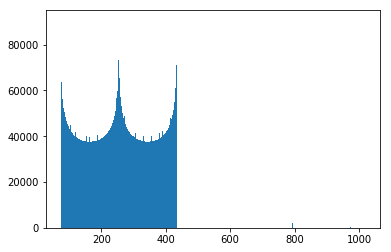

In [36]:
plt.hist(longit, bins = 900)

In [116]:
def cellIdentBool(P1, P2, P3, P4, P):
    ex = [P2[0]-P1[0],P2[1]-P1[1]]
    ey = [P4[0]-P1[0],P4[1]-P1[1]]
    exs = [P4[0]-P3[0],P4[1]-P3[1]]
    eys = [P2[0]-P3[0],P2[1]-P3[1]]
    #print('ex, ey, exs, eys:', ex, ey, exs, eys)
    
    a = np.array([[ex[0], ey[0]], [ex[1], ey[1]]])
    b = np.array([P[0]-P1[0], P[1]-P1[1]])
    #print("A, b:", a, b)
    xxx = np.linalg.solve(a, b)
    c = np.array([[exs[0], eys[0]], [exs[1], eys[1]]])
    b = np.array([P[0]-P3[0], P[1]-P3[1]])
    yyy = np.linalg.solve(c, b)
    #if ((xxx[0]>=0 == False) or ([xxx[1]>=0] == False) or ([yyy[0]>=0] == False) or ([yyy[1]>=0] == False)):
     #   return False
    #else:
    return ([xxx[0]>=0], [xxx[1]>=0], [yyy[0]>=0], [yyy[1]>=0])
    #return ((xxx[0]>=0) and (xxx[1]>=0) and (yyy[0]>=0) and (yyy[1]>=0))

In [112]:
print(cellIdentBool([-58.394382, 122.079956], [-58.352432, 122.079956], \
                    [-58.352432, 122.160034], [-58.394382, 122.160034], [-37.352833, 122.160034]))


ex, ey, exs, eys: [0.04194999999999993, 0.0] [0.0, 0.08007800000000032] [-0.04194999999999993, 0.0] [0.0, -0.08007800000000032]
A, b: [[0.04195  0.      ]
 [0.       0.080078]] [21.041549  0.080078]
([True], [True], [False], [True])


In [123]:
print(cellIdentBool([latvals[1000, 600], lngvals[1000, 600]], \
                     [latvals[1000, 601], lngvals[1000, 601]], \
                     [latvals[1001, 601], lngvals[1001, 601]], \
                     [latvals[1001, 600], lngvals[1001, 600]], \
                     [latvals[600, 599], lngvals[600, 599]]))

([False], [False], [True], [True])


In [106]:
print(cellIdentBool([0.,0.], [1.,0.], [1.,1.], [0.,1.], [-0.5,-0.6]))

ex, ey, exs, eys: [1.0, 0.0] [0.0, 1.0] [-1.0, 0.0] [0.0, -1.0]
A, b: [[1. 0.]
 [0. 1.]] [-0.5 -0.6]
False


In [107]:
print(lngvals[1516, 4498], latvals[1516, 4498])
print(lngvals[1516, 4499], latvals[1516, 4499])
print(lngvals[1516, 0], latvals[1516, 0])

434.0 0.9599551
434.07996 0.9599551
74.160034 0.9599551


### Saving data into file

### These do not run, too

In [27]:
file = open('coords.csv', 'w')
for i in range(75, 434, 10):
    for j in range(-78, 89, 10):
        res = searchPoint(j, i)
        file.write(str(j) + '; ' + str(i - 255.))
        file.write(';'+ str(latvals[res[0], res[1]]) + ',' + str(lngvals[res[0], res[1]] - 255.))
        file.write('\n')
file.close()
!more coords.csv 

-78; -180.0;-78.288,-180.0400390625
-68; -180.0;-78.288,-180.0400390625
-58; -180.0;-78.288,-180.0400390625
-48; -180.0;-78.288,-180.0400390625
-38; -180.0;-78.288,-180.0400390625
-28; -180.0;-78.288,-180.0400390625
-18; -180.0;-78.288,-180.0400390625
-8; -180.0;-78.288,-180.0400390625
2; -180.0;-78.288,-180.0400390625
12; -180.0;-78.288,-180.0400390625
22; -180.0;-78.288,-180.0400390625
32; -180.0;-78.288,-180.0400390625
42; -180.0;-78.288,-180.0400390625
52; -180.0;-78.288,-180.0400390625
62; -180.0;-78.288,-180.0400390625
72; -180.0;-78.288,-180.0400390625
82; -180.0;-78.288,-180.0400390625
-78; -170.0;-78.032,-170.0400390625
-68; -170.0;-74.288,-170.0400390625
-58; -170.0;-74.288,-170.0400390625
-48; -170.0;-74.288,-170.0400390625
-38; -170.0;-74.288,-170.0400390625
-28; -170.0;-74.288,-170.0400390625
-18; -170.0;-74.288,-170.0400390625
-8; -170.0;-74.288,-170.0400390625
2; -170.0;-74.288,-170.0400390625
12; -170.0;-74.288,-170.0400390625
22; -170.0;-74.288,-170.0400390625
32; -170

In [24]:
file = open('boolAns.txt', 'w')
for i in range(75, 434, 10):
    for j in range(-78, 89, 10):
        goal = searchPoint(j, i)
        p1 = [lngvals[j, i], latvals[j, i]] 
        p2 = [lngvals[j, imod(i+1)], latvals[j, imod(i+1)]]
        p3 = [lngvals[jmod(j+1), imod(i+1)], latvals[jmod(j+1), imod(i+1)]]
        p4 = [lngvals[jmod(j+1), i], latvals[jmod(j+1), i]]
        p = [lngvals[goal[0], goal[1]], latvals[goal[0], goal[1]]]
        res = cellIdentBool(p1, p2, p3, p4, p)[2][0]
        file.write(str(j) + ', ' + str(i - 255.))
        #cellIdentBool([0.,0.], [1.,0.], [1.,1.], [0.,1.], [-0.5,-0.6])[2][0]
        file.write(': '+ str(latvals[goal[0], goal[1]]) + ', ' + str(lngvals[goal[0], goal[1]] - 255.) + ': ' + str(res))
        file.write('\n')
file.close()
!more boolAns.txt 

-78, 75: -78.288, 74.95996: True
-68, 75: -78.288, 74.95996: True
-58, 75: -78.288, 74.95996: True
-48, 75: -78.288, 74.95996: True
-38, 75: -78.288, 74.95996: True
-28, 75: -78.288, 74.95996: True
-18, 75: -78.288, 74.95996: True
-8, 75: -78.288, 74.95996: True
2, 75: -78.288, 74.95996: True
12, 75: -78.288, 74.95996: True
22, 75: -78.288, 74.95996: True
32, 75: -78.288, 74.95996: True
42, 75: -78.288, 74.95996: True
52, 75: -78.288, 74.95996: True
62, 75: -78.288, 74.95996: True
72, 75: -78.288, 74.95996: True
82, 75: -78.288, 74.95996: True
-78, 85: -78.032, 84.95996: True
-68, 85: -74.288, 84.95996: True
-58, 85: -74.288, 84.95996: True
-48, 85: -74.288, 84.95996: True
-38, 85: -74.288, 84.95996: True
-28, 85: -74.288, 84.95996: True
-18, 85: -74.288, 84.95996: True
-8, 85: -74.288, 84.95996: True
2, 85: -74.288, 84.95996: False
12, 85: -74.288, 84.95996: False
22, 85: -74.288, 84.95996: False
32, 85: -74.288, 84.95996: False
42, 85: -74.288, 84.95996: False
52, 85: -74.288, 84.959

### Final (so far) version of cell search

In [29]:
def imod(i):
    return i % x.shape[0]

def jmod(j):
    return j % y.shape[0]

In [134]:
def searchPoint(pLat, pLng):
    if (pLat < -78.64):
        pLat = 89.
    if (pLat > 89.9502):
        pLat = -78.
    if (pLng < 74.119995):
        pLng = 494.
    if (pLng > 494.11987):
        pLng = 74.
    res = False
    i = int(x.shape[0] / 2)
    j = int(y.shape[0] / 2)
    counter = 0
    goal = [-1, -1]
    while (res == False):
        counter += 1
        if (counter > 8000):
            return [j, i, False]
        
        j = jmod(j)
        i = imod(i)
        
        #p1 = [lngvals[j, i], latvals[j, i]] 
        #p2 = [lngvals[j, imod(i+1)], latvals[j, imod(i+1)]]
        #p3 = [lngvals[jmod(j+1), imod(i+1)], latvals[jmod(j+1), imod(i+1)]]
        #p4 = [lngvals[jmod(j+1), i], latvals[jmod(j+1), i]]
        #p = [pLng, pLat]
        p1 = [latvals[j, i], lngvals[j, i]] 
        p2 = [latvals[j, imod(i+1)], lngvals[j, imod(i+1)]]
        p3 = [latvals[jmod(j+1), imod(i+1)], lngvals[jmod(j+1), imod(i+1)]]
        p4 = [latvals[jmod(j+1), i], lngvals[jmod(j+1), i]]
        p = [pLat, pLng]
        out = cellIdentBool(p1, p2, p3, p4, p)
        #if (counter > 7990):
            #print(out)
        if ((not out[0][0]) | (not out[1][0])) :
            if (not out[0][0]):
                i = imod((i-1))
            if (not out[1][0]):
                j = jmod((j-1))
        else:
            if (not out[2][0]):
                i = imod((i+1))
            if (not out[3][0]):
                j = jmod((j+1))
        if ((out[0][0]) and (out[1][0]) and (out[2][0]) and (out[1][0])):
            res = True
            goal = [j, i, res]
    return goal

In [135]:
print(latvals[1000, 600], lngvals[1000, 600])
print(latvals[600, 599], lngvals[600,599])
print(latvals[601, 599], lngvals[601,599])
print(latvals[600, 600], lngvals[600,600])
print(latvals[601, 600], lngvals[601,600])

-37.352833 122.160034
-58.394382 122.079956
-58.352432 122.079956
-58.394382 122.160034
-58.352432 122.160034


In [136]:
searchPoint(latvals[1000, 600], lngvals[1000, 600])

[1000, 600, True]

In [137]:
goal = searchPoint(0., 1.)
print(goal)
print(goal == None)
if (goal != None):
    print(latvals[goal[0], goal[1]], lngvals[goal[0], goal[1]])

[1504, 4499, False]
False
0.0 434.07996


In [138]:
#3298 4500 
def cellRho(lats, lngs):
    # takes two arrays with first 4 comps as coords of cell knots and fifth comps as coords of given point
    return np.sqrt(sum(((lats[i] - lats[4])**2 + (lngs[i] - lngs[4])**2) for i in range(0, 4)))

def cellForm(y, x, goal):
    lats = [latvals[y, x], latvals[jmod(y+1), x], latvals[y, imod(x+1)], latvals[jmod(y+1), imod(x+1)], goal[0]]
    lngs = [lngvals[y, x], lngvals[jmod(y+1), x], lngvals[y, imod(x+1)], lngvals[jmod(y+1), imod(x+1)], goal[1]]
    return [lats, lngs]

def cellRhoMinimize(LL, goal, booly):
    res = cellRho(cellForm(LL[0], LL[1], goal)[0], cellForm(LL[0], LL[1], goal)[1])
    igoal = LL[1]
    jgoal = LL[0]
    
    if (booly == True):
        eps = 20
    else:
        eps = 300
        
    i = imod(LL[1] - eps)
    j = jmod(LL[0] - eps)
    counter1 = 0
    counter2 = 0
    while (counter1 < 2 * eps):
        while (counter2 < 2 * eps):
            counter2 += 1
            actualRho = cellRho(cellForm(j, i, goal)[0], cellForm(j, i, goal)[1])
            #print('i, j, rho: ' + str(i) + '  ' + str(j) + '  ' + str(actualRho))
            if (actualRho < res):
                res = actualRho
                igoal = i
                jgoal = j
            i = imod(i + 1)
        counter2 = 0
        counter1 += 1
        j = jmod(j + 1)
        i = imod(LL[1] - eps)
            
    return [res, jgoal, igoal]

In [149]:
def minim(pLat, pLng):
    result = searchPoint(pLat, pLng)
    LL = result[0:2] #returns [j,i]
    booly = result[2]

    LU = [jmod(LL[0] + 1), LL[1]]
    RL = [LL[0], imod(LL[1] + 1)]
    RU = [jmod(LL[0] + 1), imod(LL[0] + 1)]
    localLats = [latvals[LL[0], LL[1]], latvals[LU[0], LU[1]], latvals[RL[0], RL[1]], latvals[RU[0], RU[1]], pLat]
    localLngs = [lngvals[LL[0], LL[1]], lngvals[LU[0], LU[1]], lngvals[RL[0], RL[1]], lngvals[RU[0], RU[1]], pLng]
    print('given: ' + str(pLat) + ', ' + str(pLng))
    print('LL: ' + str(LL[0]) + ', ' + str(LL[1]))
    print('LU: ' + str(LU[0]) + ', ' + str(LU[1]))
    print('RL: ' + str(RL[0]) + ', ' + str(RL[1]))
    print('RU: ' + str(RU[0]) + ', ' + str(RU[1]))
    print('coords of cell are: \n' + str(latvals[LL[0], LL[1]]) + ', ' + str(lngvals[LL[0], LL[1]]) + '\n')
    print(str(latvals[LU[0], LU[1]]) + ', ' + str(lngvals[LU[0], LU[1]]) + '\n')
    print(str(latvals[RL[0], RL[1]]) + ', ' + str(lngvals[RL[0], RL[1]]) + '\n')
    print(str(latvals[RU[0], RU[1]]) + ', ' + str(lngvals[RU[0], RU[1]]) + '\n')
    res = cellRhoMinimize(LL, [pLat, pLng], booly)
    rho = res[0]
    jgoal = res[1]
    igoal = res[2]
    booly = result[2]
    print('distance in cell is: ')
    print('rho ' + str(rho))
    print('j ' + str(jgoal))
    print('i ' + str(igoal))
    return res, booly
    
print(minim(0., 1.))
print(minim(latvals[1000, 600], lngvals[1000, 600]))

given: 0.0, 1.0
LL: 1504, 4499
LU: 1505, 4499
RL: 1504, 0
RU: 1505, 1505
coords of cell are: 
0.0, 434.07996

0.079999976, 434.07996

0.0, 74.160034

0.079999976, 194.56006

distance in cell is: 
rho 146.40008996377378
j 1503
i 0
([146.40008996377378, 1503, 0], False)
given: -37.352833, 122.160034
LL: 1000, 600
LU: 1001, 600
RL: 1000, 601
RU: 1001, 1001
coords of cell are: 
-37.352833, 122.160034

-37.28921, 122.160034

-37.352833, 122.23999

-37.28921, 154.23999

distance in cell is: 
rho 0.14445339029571064
j 999
i 600
([0.14445339029571064, 999, 600], True)


### Bilinear interpolation

In [ ]:
MT = mt[:]
print(v[0, :, 100, 100].shape)
speed = np.zeros((dep.shape[0], y.shape[0], x.shape[0]))
for i in range(len(dep)):
    speed[i, :, :] = v[0, i, :, :]

In [ ]:
print(speed[0, 100, 100])

In [142]:
def bilinInterpol(point, dep = 0):
    cellInfo, booly = minim(point[0], point[1])
    cellLL = cellInfo[1:3]
    cellLU = [jmod(cellLL[0] + 1), imod(cellLL[1])]
    cellRL = [jmod(cellLL[0]), imod(cellLL[1] + 1)]
    cellRU = [jmod(cellLL[0] + 1), imod(cellLL[1] + 1)]
    vPoint = 0.
    isWater = False
    x1 = (lngvals[cellLL[0], cellLL[1]] + lngvals[cellLU[0], cellLU[1]]) / 2
    x2 = (lngvals[cellRL[0], cellRL[1]] + lngvals[cellRU[0], cellRU[1]]) / 2
    y1 = (latvals[cellLL[0], cellLL[1]] + latvals[cellRL[0], cellRL[1]]) / 2
    y2 = (latvals[cellLU[0], cellLU[1]] + latvals[cellRU[0], cellRU[1]]) / 2

    
    if (speed[dep, cellLL[0], cellLL[1]] < 1e+30):
        isWater = True
        v11 = speed[dep, cellLL[0], cellLL[1]]
        print(v11)
        vPoint += (v11 * (x2-point[1]) * (y2-point[0])) / ((x2-x1)*(y2-y1))
    if (speed[dep, cellRL[0], cellRL[1]] < 1e+30):
        isWater = True
        v21 = speed[dep, cellRL[0], cellRL[1]]
        print(v21)
        vPoint += (v21 * (point[1]-x1) * (y2-point[0])) / ((x2-x1)*(y2-y1))
    if (speed[dep, cellLU[0], cellLU[1]] < 1e+30):
        isWater = True
        v12 = speed[dep, cellLU[0], cellLU[1]]
        print(v12)
        vPoint += (v12 * (x2-point[1]) * (point[0] - y1)) / ((x2-x1)*(y2-y1))
    if (speed[dep, cellRU[0], cellRU[1]] < 1e+30):
        isWater = True
        v22 = speed[dep, cellRU[0], cellRU[1]]
        print(v22)
        vPoint += (v22 * (point[1]-x1) * (point[0]-y1)) / ((x2-x1)*(y2-y1))
    print('vpoint: ', vPoint)
        
    
bilinInterpol([-37., 122.])

given: -37.0, 122.0
LL: 1005, 598
LU: 1006, 598
RL: 1005, 599
RU: 1006, 1006
coords of cell are: 
-37.034195, 122.0

-36.970306, 122.0

-37.034195, 122.079956

-36.970306, 154.64001

distance in cell is: 
rho 0.1299536465255631
j 1005
i 598
0.34933704137802124
0.4193742275238037
0.6143017411231995
0.5562819838523865
vpoint:  0.4911535907281393


In [145]:
bilinInterpol([1., 140.])

given: 1.0, 140.0
LL: 1516, 823
LU: 1517, 823
RL: 1516, 824
RU: 1517, 1517
coords of cell are: 
0.9599551, 140.0

1.0399429, 140.0

0.9599551, 140.07996

1.0399429, 195.52002

distance in cell is: 
rho 0.13850629668812905
j 1516
i 823
Point:  [1.0, 140.0]
x1: 140.0
x2: 140.0799560546875
y1: 0.959955096244812
y2: 1.0399428606033325
alphs:  0.49936213274196484 0.0 0.5006378672580352 0.0
-0.16539323329925537
-0.16466611623764038
-0.13382942974567413
-0.13059495389461517
vpoint:   -0.14959119800563886


In [ ]:
def bilin(point, dep = 0):
    cellInfo = minim(point[0], point[1])
    cellLL = cellInfo[1:3]
    cellLU = [cellLL[0] + 1, cellLL[1]]
    cellRL = [cellLL[0], cellLL[1] + 1]
    cellRU = [cellLL[0] + 1, cellLL[1] + 1]
    vPoint = 0.
    isWater = False
    
    
    if (speed[dep, cellLL[0], cellLL[1]] < 1e+30):
        isWater = True
        v11 = speed[dep, cellLL[0], cellLL[1]]
        print(v11)
        vPoint += (v11 * (x2-point[1]) * (y2-point[0])) / ((x2-x1)*(y2-y1))
    if (speed[dep, cellRL[0], cellRL[1]] < 1e+30):
        isWater = True
        v21 = speed[dep, cellRL[0], cellRL[1]]
        print(v21)
        vPoint += (v21 * (point[1]-x1) * (y2-point[0])) / ((x2-x1)*(y2-y1))
    if (speed[dep, cellLU[0], cellLU[1]] < 1e+30):
        isWater = True
        v12 = speed[dep, cellLU[0], cellLU[1]]
        print(v12)
        vPoint += (v12 * (x2-point[1]) * (point[0] - y1)) / ((x2-x1)*(y2-y1))
    if (speed[dep, cellRU[0], cellRU[1]] < 1e+30):
        isWater = True
        v22 = speed[dep, cellRU[0], cellRU[1]]
        print(v22)
        vPoint += (v22 * (point[1]-x1) * (point[0]-y1)) / ((x2-x1)*(y2-y1))
    print(vPoint)

In [205]:
def bilinInterpol(point, dep = 0):
    cellInfo, booly = minim(point[0], point[1])
    cellLL = cellInfo[1:3]
    cellLU = [jmod(cellLL[0] + 1), imod(cellLL[1])]
    cellRL = [jmod(cellLL[0]), imod(cellLL[1] + 1)]
    cellRU = [jmod(cellLL[0] + 1), imod(cellLL[1] + 1)]
    vPoint = 0.
    isWater = False
    
    x1 = (lngvals[cellLL[0], cellLL[1]] + lngvals[cellLU[0], cellLU[1]]) / 2
    x2 = (lngvals[cellRL[0], cellRL[1]] + lngvals[cellRU[0], cellRU[1]]) / 2
    y1 = (latvals[cellLL[0], cellLL[1]] + latvals[cellRL[0], cellRL[1]]) / 2
    y2 = (latvals[cellLU[0], cellLU[1]] + latvals[cellRU[0], cellRU[1]]) / 2
    
        #xLL = [latvals[cellLL[0], cellLL[1]], lngvals[cellLL[0], cellLL[1]]]
        #xLU = [latvals[cellLU[0], cellLU[1]], lngvals[cellRU[0], cellRU[1]]]
        #xRL = [latvals[cellLL[0], cellLL[1]], lngvals[cellRL[0], cellRL[1]]]
        #xRU = [latvals[cellLU[0], cellLU[1]], lngvals[cellRU[0], cellRU[1]]]
    
        #x1 = (xLL + xLU)/2
        #x2 = (xRL + xRU)/2
        #y1 = (yLL + yRl)/2
        #y2 = (yLU + yRU)/2
    print('Point: ', point)
    print('x1:' , x1)
    print('x2:' , x2)
    print('y1:' , y1)
    print('y2:' , y2)
    
    alpha11 = (x2-point[1]) * (y2-point[0]) / ((x2-x1)*(y2-y1))
    alpha21 = (point[1]-x1) * (y2-point[0]) / ((x2-x1)*(y2-y1))
    alpha12 = (x2-point[1]) * (point[0] - y1) / ((x2-x1)*(y2-y1))
    alpha22 = (point[1]-x1) * (point[0]-y1) / ((x2-x1)*(y2-y1))
    print('alphs: ', alpha11, alpha21, alpha12, alpha22)
    
    if ((alpha11 > 1) or (alpha21 > 1) or (alpha12 > 1) or (alpha22 > 1)):
        sum1 = m.fabs(alpha11) + m.fabs(alpha12)
        sum2 = m.fabs(alpha21) + m.fabs(alpha22)
        alpha11 /= sum1
        alpha21 /= sum2
        alpha12 /= sum1
        alpha22 /= sum2
        print('alphs: ', alpha11, alpha21, alpha12, alpha22)
        
    if (speed[dep, cellLL[0], cellLL[1]] < 1e+30):
        isWater = True
        v11 = speed[dep, cellLL[0], cellLL[1]]
        print(v11)
        vPoint += v11 * alpha11

    if (speed[dep, cellRL[0], cellRL[1]] < 1e+30):
        isWater = True
        v21 = speed[dep, cellRL[0], cellRL[1]]
        print(v21)
        vPoint += v21 * alpha21
    if (speed[dep, cellLU[0], cellLU[1]] < 1e+30):
        isWater = True
        v12 = speed[dep, cellLU[0], cellLU[1]]
        print(v12)
        vPoint += v12 * alpha12
    if (speed[dep, cellRU[0], cellRU[1]] < 1e+30):
        isWater = True
        v22 = speed[dep, cellRU[0], cellRU[1]]
        print(v22)
        vPoint += v22 * alpha22
    print('vpoint:  ', vPoint)
        
bilinInterpol([latvals[600, 600],lngvals[600, 600]])

given: -58.394382, 122.160034
LL: 600, 600
LU: 601, 600
RL: 600, 601
RU: 601, 601
coords of cell are: 
-58.394382, 122.160034

-58.352432, 122.160034

-58.394382, 122.23999

-58.352432, 122.23999

distance in cell is: 
rho 0.12766075258240328
j 599
i 600
Point:  [-58.394382, 122.160034]
x1: 122.1600341796875
x2: 122.239990234375
y1: -58.436283111572266
y2: -58.39438247680664
alphs:  0.0 0.0 1.0 0.0
-0.1080707311630249
-0.11415880918502808
-0.1086902916431427
-0.11434556543827057
vpoint:   -0.1086902916431427


In [167]:
bilinInterpol([12., 100.])

given: 12.0, 100.0
LL: 1650, 323
LU: 1651, 323
RL: 1650, 324
RU: 1651, 1651
coords of cell are: 
11.599934, 100.0

11.678288, 100.0

11.599934, 100.079956

11.678288, 206.23999

distance in cell is: 
rho 0.15051630122946152
j 1655
i 322
Point:  [12.0, 100.0]
x1: 99.9200439453125
x2: 100.0
y1: 11.991485595703125
y2: 12.06972885131836
alphs:  0.0 0.8911803422553751 0.0 0.10881965774462483
0.030082054436206818
0.07324143499135971
0.06368417292833328
vpoint:   0.07220141700468548


In [168]:
bilinInterpol([0., 75.])

given: 0.0, 75.0
LL: 1504, 10
LU: 1505, 10
RL: 1504, 11
RU: 1505, 1505
coords of cell are: 
0.0, 74.95996

0.079999976, 74.95996

0.0, 75.04004

0.079999976, 194.56006

distance in cell is: 
rho 0.1386091569080298
j 1504
i 10
Point:  [0.0, 75.0]
x1: 74.9599609375
x2: 75.0400390625
y1: 0.0
y2: 0.07999997586011887
alphs:  0.5 0.5 0.0 0.0
-0.4026387929916382
-0.3798072636127472
-0.41124409437179565
-0.3899849057197571
vpoint:   -0.3912230283021927


In [197]:
bilinInterpol([-55., 84.])

given: -55.0, 84.0
LL: 677, 123
LU: 678, 123
RL: 677, 124
RU: 678, 678
coords of cell are: 
-55.015617, 84.0

-54.969723, 84.0

-55.015617, 84.079956

-54.969723, 128.40002

distance in cell is: 
rho 0.1229112276924763
j 677
i 123
Point:  [-55.0, 84.0]
x1: 84.0
x2: 84.0799560546875
y1: -55.01561737060547
y2: -54.969722747802734
alphs:  0.6597124096085113 0.0 0.34028759039148865 0.0
0.20805317163467407
0.22458869218826294
0.18704774975776672
0.202691912651062
vpoint:   0.2009052872390246


In [198]:
bilinInterpol([70., 400.])

given: 70.0, 400.0
LL: 2894, 3851
LU: 2895, 3851
RL: 2894, 3852
RU: 2895, 2895
coords of cell are: 
69.99219, 399.93896

70.01278, 399.99817

69.96649, 400.0155

69.9355, 288.01294

distance in cell is: 
rho 0.10510317539726913
j 2894
i 3851
Point:  [70.0, 400.0]
x1: 399.96856689453125
x2: 400.0450439453125
y1: 69.97933959960938
y2: 69.99991607666016
alphs:  -0.0024022435143419975 -0.0016763623440191446 0.5913886760761936 0.41268992978216756
-0.038998354226350784
-0.03870848938822746
-0.045588333159685135
-0.046397577971220016
vpoint:   -0.04594966418931751


In [206]:
bilinInterpol([80., 400.])

given: 80.0, 400.0
LL: 3039, 3639
LU: 3040, 3639
RL: 3039, 3640
RU: 3040, 3040
coords of cell are: 
78.28877, 391.8496

78.31114, 391.9558

78.26569, 391.96777

76.58691, 288.92493

distance in cell is: 
rho 8.381937300102951
j 3058
i 3658
Point:  [80.0, 400.0]
x1: 396.14306640625
x2: 396.251953125
y1: 78.2293930053711
y2: 78.24986267089844
alphs:  2943.008285016605 -3028.5073532238357 -2977.4298096802822 3063.928877887513
alphs:  0.49709299175896215 -0.49709299175896204 -0.502907008241038 0.5029070082410378
0.008577344007790089
0.01948188990354538
0.02033000811934471
0.03249403089284897
vpoint:   0.0006967989581049654


In [209]:
bilinInterpol([80., 100.])

given: 80.0, 100.0
LL: 1650, 323
LU: 1651, 323
RL: 1650, 324
RU: 1651, 1651
coords of cell are: 
11.599934, 100.0

11.678288, 100.0

11.599934, 100.079956

11.678288, 206.23999

distance in cell is: 
rho 133.7526444552326
j 1669
i 322
Point:  [80.0, 100.0]
x1: 99.9200439453125
x2: 100.0
y1: 13.084757804870605
y2: 13.162668228149414
alphs:  -0.0 -857.8740681804272 0.0 858.8740681804272
alphs:  nan -0.4997087516861618 nan 0.5002912483138382
vpoint:   0.0


C:\Users\Nina\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Nina\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


In [179]:
bilinInterpol([-25., 200.])

given: -25.0, 200.0
LL: 1181, 1573
LU: 1182, 1573
RL: 1181, 1574
RU: 1182, 1182
coords of cell are: 
-25.006115, 200.0

-24.933592, 200.0

-25.006115, 200.07996

-24.933592, 168.71997

distance in cell is: 
rho 0.14724406117714434
j 1181
i 1573
Point:  [-25.0, 200.0]
x1: 200.0
x2: 200.0799560546875
y1: -25.006114959716797
y2: -24.933591842651367
alphs:  0.9156826131551955 0.0 0.08431738684480446 0.0
0.2610677182674408
0.37350308895111084
0.30270588397979736
0.37038594484329224
vpoint:   0.2645785395933176


In [187]:
bilinInterpol([-78., 200.])

given: -78.0, 200.0
LL: 20, 1573
LU: 21, 1573
RL: 20, 1574
RU: 21, 21
coords of cell are: 
-78.0, 200.0

-77.968, 200.0

-78.0, 200.07996

-77.968, 75.839966

distance in cell is: 
rho 0.12179345014465934
j 20
i 1573
Point:  [-78.0, 200.0]
x1: 200.0
x2: 200.0799560546875
y1: -78.0
y2: -77.96800231933594
alphs:  1.0 0.0 0.0 0.0
0.002823450369760394
0.0012201801873743534
0.00413831602782011
0.0013449174584820867
vpoint:   0.002823450369760394


## New bilinear Interpolation

In [238]:
def triangleInterpol(point, dep = 0):
    cellInfo, booly = minim(point[0], point[1])
    cellLL = cellInfo[1:3]
    cellLU = [jmod(cellLL[0] + 1), imod(cellLL[1])]
    cellRL = [jmod(cellLL[0]), imod(cellLL[1] + 1)]
    cellRU = [jmod(cellLL[0] + 1), imod(cellLL[1] + 1)]
    vPoint = 0.
    isWater = False
    
    angles = np.zeros((4,3))
    
    xLL = [latvals[cellLL[0], cellLL[1]], lngvals[cellLL[0], cellLL[1]]]
    xLU = [latvals[cellLU[0], cellLU[1]], lngvals[cellRU[0], cellRU[1]]]
    xRL = [latvals[cellLL[0], cellLL[1]], lngvals[cellRL[0], cellRL[1]]]
    xRU = [latvals[cellLU[0], cellLU[1]], lngvals[cellRU[0], cellRU[1]]]
    an1 = cosan(xLL, xLU, xRL)
    an2 = cosan(xLU, xRL, xLL)
    an3 = cosan(xRL, xLL, xLU)
    an4 = cosan(xLU, xRU, xRL)
    an5 = cosan(xRL, xLU, xRU)
    an6 = cosan(xRU, xRL, xLU)
    
    angles[0] = [an1, an2, an3]
    angles[1] = [an4, an5, an6]
    
    
    #чем меньше an, тем больше угол
    
    an7 = cosan(xLL, xLU, xRU)
    an8 = cosan(xLU, xRU, xLL)
    an9 = cosan(xRU, xLL, xLU)
    an10 = cosan(xRU, xRL, xLL)
    an11 = cosan(xRL, xRU, xLL)
    an12 = cosan(xLL, xRU, xRL)
    
    angles[2] = [an7, an8, an9]
    angles[3] = [an10, an11, an12]
    
    booly1 = [trianIdentBool(xLL, xRL, xLU, point), trianIdentBool(xRU, xRL, xLU, point)]
    booly2 = [trianIdentBool(xLL, xLU, xRU, point), trianIdentBool(xLL, xRU, xRL, point)]
    if (booly1[0] == True):
        max1 = min(angles[0])
        if(booly2[0] == True):
            max2 = min(angles[2])
            if (max1 < max2):
                trNum = [xLL, xRL, xLU]
            else:
                trNum = [xLL, xLU, xRU]
        elif(booly2[1] == True):
            max2 = min(angles[3])
            if (max1 < max2):
                trNum = [xLL, xRL, xLU]
            else:
                trNum = [xLL, xRU, xRL]
    elif(booly1[1] == True):
        max1 = min(angles[1])
        if(booly2[0] == True):
            max2 = min(angles[2])
            if (max1 < max2):
                trNum = [xRU, xRL, xLU]
            else:
                trNum = [xLL, xLU, xRU]
        elif(booly2[1] == True):
            max2 = min(angles[3])
            if (max1 < max2):
                trNum = [xRU, xRL, xLU]
            else:
                trNum = [xLL, xRU, xRL]
    
    print('Point: ', point)
    print('x1:' , trNum[0])
    print('x2:' , trNum[1])
    print('x3:' , trNum[2])
    
    
    weight = np.zeros(3)
    xxx = basicCoords(trNum[0], trNum[1], trNum[2], point)
    weight[0] = 1 - xxx[0] - xxx[1]
    xxx = basicCoords(trNum[1], trNum[2], trNum[0], point)
    weight[1] = 1 - xxx[0] - xxx[1]
    xxx = basicCoords(trNum[2], trNum[0], trNum[1], point)
    weight[2] = 1 - xxx[0] - xxx[1]
    print('Weights: ', weight[0], weight[1], weight[2])
    
    
    if (speed[dep, trNum[0][0], trNum[0][1]] < 1e+30):
        isWater = True
        v11 = speed[dep, trNum[0][0], trNum[0][1]]
        print(v11)
        vPoint += v11 * weight[0]

    if (speed[dep, trNum[1][0], cellRL[1][1]] < 1e+30):
        isWater = True
        v21 = speed[dep, trNum[1][0], trNum[1][1]]
        print(v21)
        vPoint += v21 * weight[1]
        
    if (speed[dep, trNum[2][0], trNum[2][1]] < 1e+30):
        isWater = True
        v12 = speed[dep, trNum[2][0], trNum[2][1]]
        print(v12)
        vPoint += v12 * weight[2]
    

    print('vpoint:  ', vPoint)

In [241]:
def leng(x1, x2):
    return np.sqrt((x2[0] - x1[0]) ** 2 + (x2[1] - x1[1]) ** 2)

def scal(x1, x2, x3):
    return (x2[1] - x1[1]) * (x3[1] - x1[1]) + (x2[0] - x1[0]) * (x3[0] - x1[0])

def cosan(x1, x2, x3):
    return scal(x1, x2, x3) / (leng(x1, x2) * leng(x1, x3))

def trianIdentBool(P1, P2, P3, P):
    ex = [P2[0]-P1[0],P2[1]-P1[1]]
    ey = [P3[0]-P1[0],P3[1]-P1[1]]
    exs = [P1[0]-P2[0],P1[1]-P2[1]]
    eys = [P3[0]-P2[0],P3[1]-P2[1]]
    #print('ex, ey, exs, eys:', ex, ey, exs, eys)
    
    a = np.array([[ex[0], ey[0]], [ex[1], ey[1]]])
    b = np.array([P[0]-P1[0], P[1]-P1[1]])
    #print("A, b:", a, b)
    xxx = np.linalg.solve(a, b)
    c = np.array([[exs[0], eys[0]], [exs[1], eys[1]]])
    b = np.array([P[0]-P3[0], P[1]-P3[1]])
    yyy = np.linalg.solve(c, b)
    return ((xxx[0]>=0) and (xxx[1]>=0) and (yyy[0]>=0) and (yyy[1]>=0))

def basicCoords(P1, P2, P3, P):
    ex = [P2[0]-P1[0],P2[1]-P1[1]]
    ey = [P3[0]-P1[0],P3[1]-P1[1]]
    #print('ex, ey, exs, eys:', ex, ey, exs, eys)
    
    a = np.array([[ex[0], ey[0]], [ex[1], ey[1]]])
    b = np.array([P[0]-P1[0], P[1]-P1[1]])
    #print("A, b:", a, b)
    xxx = np.linalg.solve(a, b)
    return xxx

In [242]:
triangleInterpol([10., 78.])

given: 10.0, 78.0
LL: 1629, 48
LU: 1630, 48
RL: 1629, 49
RU: 1630, 1630
coords of cell are: 
9.949614, 78.0

10.028401, 78.0

9.949614, 78.079956

10.028401, 204.56006

distance in cell is: 
rho 0.13955931343499783
j 1629
i 48


C:\Users\Nina\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


LinAlgError: Singular matrix